In [253]:
### Motor Imagery EEG Data Preprocessing

In [254]:
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import numpy as np
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import numpy as np


In [255]:
subject = 2
runs = [6, 10, 14]     # all Task 4: imagined fists vs feet

fnames = eegbci.load_data(subject, runs)
raw_list = [read_raw_edf(f, preload=True) for f in fnames]

raw = concatenate_raws(raw_list)


mne.datasets.eegbci.standardize(raw)

montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage)


Extracting EDF parameters from /Users/light/Desktop/university/aml/datasets/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/light/Desktop/university/aml/datasets/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R10.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/light/Desktop/university/aml/datasets/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R14.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


<RawEDF | S002R06.edf, 64 x 59040 (369.0 s), ~28.9 MiB, data loaded>

In [256]:
raw.filenames

(PosixPath('/Users/light/Desktop/university/aml/datasets/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf'),
 PosixPath('/Users/light/Desktop/university/aml/datasets/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R10.edf'),
 PosixPath('/Users/light/Desktop/university/aml/datasets/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R14.edf'))

In [ ]:
events, event_id = mne.events_from_annotations(raw)

print(event_id) 

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


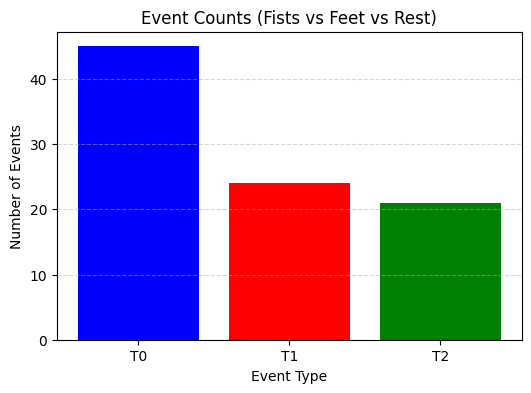

In [258]:
label_map = {v: k for k, v in event_id.items()}

unique, counts = np.unique(events[:, 2], return_counts=True)

labels = [label_map[u] for u in unique]

plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=['blue', 'red', 'green'])
plt.title("Event Counts (Fists vs Feet vs Rest)")
plt.ylabel("Number of Events")
plt.xlabel("Event Type")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [259]:
raw_filtered = raw.copy().filter(8., 30., fir_design='firwin')

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



In [260]:
events, event_id = mne.events_from_annotations(raw_filtered)
print(event_id)

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


In [261]:
epochs = mne.Epochs(
    raw_filtered,
    events,
    event_id={'fists': 2, 'feet': 3},
    tmin=0,
    tmax=4.0,   # 4 second trials
    baseline=None,
    preload=True
)


Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped


In [262]:
print("Fists:", len(epochs['fists']))
print("Feet:", len(epochs['feet']))


Fists: 24
Feet: 21


In [263]:
X = epochs.get_data()           
X = X[..., np.newaxis]          

y = epochs.events[:, 2]         # event codes: 2=fists, 3=feet
y = np.where(y == 2, 0, 1)      # convert: 0=fists, 1=feet


In [ ]:
print(X.shape)  
print(y.shape)   


(45, 64, 641, 1)
(45,)


In [265]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical
y_cat = to_categorical(y, num_classes=2)

# 60% train — 20% val — 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_cat, test_size=0.4, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (27, 64, 641, 1)
Val: (9, 64, 641, 1)
Test: (9, 64, 641, 1)


In [266]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, DepthwiseConv2D
from tensorflow.keras.layers import SeparableConv2D, AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.regularizers import l2

def EEGNet(nb_classes, Chans=64, Samples=641, 
           dropoutRate=0.5, kernelLength=64, F1=8, 
           D=2, F2=16):

    input1 = Input(shape=(Chans, Samples, 1))

    # === BLOCK 1 ===
    x = Conv2D(
        F1, 
        (1, kernelLength),
        padding='same',
        kernel_regularizer=l2(0.001)
    )(input1)
    
    x = BatchNormalization()(x)

    x = DepthwiseConv2D(
        (Chans, 1),
        depth_multiplier=D,
        depthwise_regularizer=l2(0.001),
        padding='valid'
    )(x)

    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropoutRate)(x)

    # === BLOCK 2 ===
    x = SeparableConv2D(
        F2,
        (1, 16),
        padding='same',
        depthwise_regularizer=l2(0.001),
        pointwise_regularizer=l2(0.001)
    )(x)

    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = AveragePooling2D((1, 8))(x)
    x = Dropout(dropoutRate)(x)

    # === CLASSIFIER ===
    x = Flatten()(x)
    output = Dense(nb_classes, activation='softmax')(x)

    return Model(inputs=input1, outputs=output)


In [267]:
model = EEGNet(nb_classes=2, Chans=64, Samples=641)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 64, 641, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 641, 8)     │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 64, 641, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_21             │ (None, 1, 641, 16)     │         1,040 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 1, 641, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 1, 641, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_37            │ (None, 1, 160, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 1, 160, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_19             │ (None, 1, 160, 16)     │           528 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 1, 160, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 1, 160, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_38            │ (None, 1, 20, 16)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 1, 20, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │           642 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,890 (11.29 KB)

 Trainable params: 2,810 (10.98 KB)

 Non-trainable params: 80 (320.00 B)

In [268]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_eegnet_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [269]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=8,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5556 - loss: 0.7176
Epoch 1: val_loss improved from None to 0.71702, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.5185 - loss: 0.7180 - val_accuracy: 0.5556 - val_loss: 0.7170
Epoch 2/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7222 - loss: 0.7122
Epoch 2: val_loss improved from 0.71702 to 0.71672, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6296 - loss: 0.7142 - val_accuracy: 0.5556 - val_loss: 0.7167
Epoch 3/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5833 - loss: 0.7106
Epoch 3: val_loss did not improve from 0.71672
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6296 - loss: 0.7071 - val_accuracy: 0.5556 - val_loss: 0.7168
Epoch 4/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4514 - loss: 0.7216
Epoch 4: val_loss improved from 0.71672 to 0.71661, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4444 - loss: 0.7230 - val_accuracy: 0.5556 - val_loss: 0.7166
Epoch 5/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4097 - loss: 0.7268
Epoch 5: val_loss improved from 0.71661 to 0.71635, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3704 - loss: 0.7312 - val_accuracy: 0.5556 - val_loss: 0.7163
Epoch 6/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3472 - loss: 0.7220
Epoch 6: val_loss improved from 0.71635 to 0.71627, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4815 - loss: 0.7146 - val_accuracy: 0.5556 - val_loss: 0.7163
Epoch 7/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5347 - loss: 0.7172
Epoch 7: val_loss improved from 0.71627 to 0.71607, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5556 - loss: 0.7139 - val_accuracy: 0.5556 - val_loss: 0.7161
Epoch 8/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4931 - loss: 0.7241
Epoch 8: val_loss improved from 0.71607 to 0.71582, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4815 - loss: 0.7189 - val_accuracy: 0.5556 - val_loss: 0.7158
Epoch 9/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7014 - loss: 0.7039
Epoch 9: val_loss improved from 0.71582 to 0.71541, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7037 - loss: 0.7025 - val_accuracy: 0.5556 - val_loss: 0.7154
Epoch 10/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5764 - loss: 0.7079
Epoch 10: val_loss improved from 0.71541 to 0.71503, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5185 - loss: 0.7141 - val_accuracy: 0.5556 - val_loss: 0.7150
Epoch 11/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4861 - loss: 0.7182
Epoch 11: val_loss improved from 0.71503 to 0.71490, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5926 - loss: 0.7141 - val_accuracy: 0.5556 - val_loss: 0.7149
Epoch 12/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5347 - loss: 0.7179
Epoch 12: val_loss improved from 0.71490 to 0.71479, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5556 - loss: 0.7215 - val_accuracy: 0.5556 - val_loss: 0.7148
Epoch 13/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5486 - loss: 0.7143
Epoch 13: val_loss improved from 0.71479 to 0.71474, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5926 - loss: 0.7096 - val_accuracy: 0.5556 - val_loss: 0.7147
Epoch 14/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5556 - loss: 0.7109
Epoch 14: val_loss improved from 0.71474 to 0.71460, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5926 - loss: 0.7114 - val_accuracy: 0.5556 - val_loss: 0.7146
Epoch 15/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5903 - loss: 0.7099
Epoch 15: val_loss improved from 0.71460 to 0.71454, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5185 - loss: 0.7193 - val_accuracy: 0.5556 - val_loss: 0.7145
Epoch 16/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3264 - loss: 0.7243
Epoch 16: val_loss improved from 0.71454 to 0.71435, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4815 - loss: 0.7120 - val_accuracy: 0.5556 - val_loss: 0.7143
Epoch 17/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5000 - loss: 0.7066
Epoch 17: val_loss improved from 0.71435 to 0.71424, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4815 - loss: 0.7078 - val_accuracy: 0.5556 - val_loss: 0.7142
Epoch 18/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5486 - loss: 0.7275
Epoch 18: val_loss improved from 0.71424 to 0.71419, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5185 - loss: 0.7286 - val_accuracy: 0.5556 - val_loss: 0.7142
Epoch 19/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6042 - loss: 0.7019
Epoch 19: val_loss improved from 0.71419 to 0.71407, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5926 - loss: 0.7085 - val_accuracy: 0.5556 - val_loss: 0.7141
Epoch 20/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8542 - loss: 0.6869
Epoch 20: val_loss improved from 0.71407 to 0.71388, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7778 - loss: 0.6927 - val_accuracy: 0.5556 - val_loss: 0.7139
Epoch 21/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5764 - loss: 0.6933
Epoch 21: val_loss improved from 0.71388 to 0.71368, saving model to best_eegnet_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6667 - loss: 0.6939 - val_accuracy: 0.5556 - val_loss: 0.7137
Epoch 22/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6389 - loss: 0.7136
Epoch 22: val_loss did not improve from 0.71368
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7037 - loss: 0.6908 - val_accuracy: 0.5556 - val_loss: 0.7137
Epoch 23/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5139 - loss: 0.6839
Epoch 23: val_loss did not improve from 0.71368
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5926 - loss: 0.6842 - val_accuracy: 0.5556 - val_loss: 0.7138
Epoch 24/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4653 - loss: 0.7056
Epoch 24: val_loss did not improve from 0.71368
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5185 - loss: 0.6973 - val_accuracy: 0.5556 - val_loss: 0.7140
Epoch 25/80
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7569 - loss: 0.6491
Epoch 25: val_loss did not improve from 0.71368
4/4 ━━━━━━━━━━━━

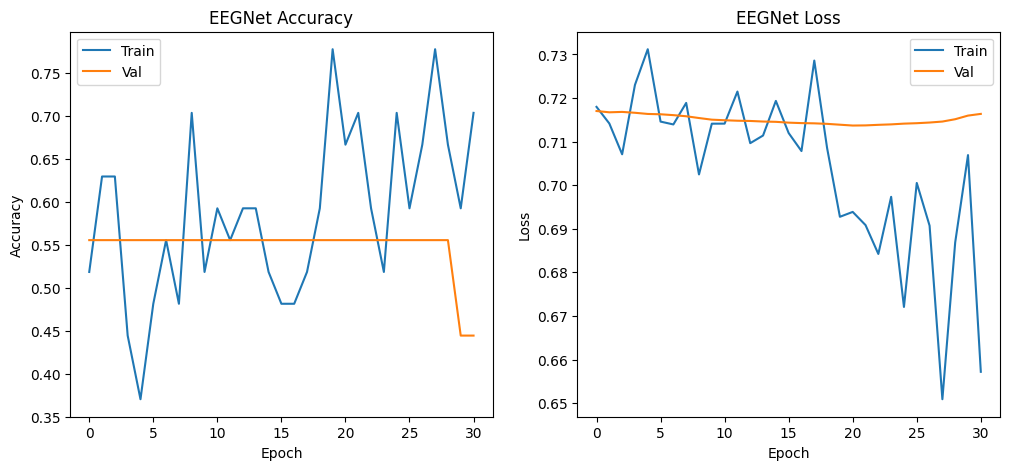

In [270]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("EEGNet Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"])

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("EEGNet Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])

plt.show()


In [271]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("TEST ACCURACY =", test_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5556 - loss: 0.7137
TEST ACCURACY = 0.5555555820465088
